# E [$B_x \cdot B_y] $

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob
from scipy.stats import normaltest, gaussian_kde, probplot
from scipy.optimize import curve_fit
import time
from tqdm import tqdm

In [2]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
noise_values = np.logspace(start = -8, stop = 2, num = 100)
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

## Constant K

In [31]:
num_exp = 100
noise_values = np.logspace(start = -8, stop = 2, num = 100)
summands_lists = [] * len(noise_values)
summands_means = np.zeros(len(noise_values))
B_xs = np.zeros((resolution, resolution, len(noise_values)))

total_sum_df = pd.DataFrame(columns=['Noise', 'Abs_Sum'])
k = np.random.randint(1, resolution + 1, size=2)

for noise in tqdm(noise_values):
    for i in range(num_exp):
        # Randomly select image indexes and category indexes
        image_indexes = np.random.randint(0, 10, 2)
        category_indexes = np.random.randint(0, 10, 2)
        
        # Create image instances
        image1 = Image(resolution, category_names[category_indexes[0]], image_numbers[image_indexes[0]], full_path)
        image2 = Image(resolution, category_names[category_indexes[1]], image_numbers[image_indexes[1]], full_path)
        
        # Process images
        results = Image.process_images(image1, image2, noise)
        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1

        sum_left = 0
        sum_right = 0
        # k = np.random.randint(1, resolution + 1, size=2)
        
        # Calculate sum_left and sum_right according to line 44
        for x in range(resolution):
            for y in range(resolution):
                B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                location = np.array([x, y])
                exponent = np.exp(-1j * np.dot(location, k))
                sum_left += exponent * B_x
                exponent = np.exp(1j * np.dot(location, k))
                sum_right += exponent * B_x
        
        # Compute absolute sum
        abs_sum = abs(sum_left * sum_right)
        
        # Append results to DataFrame
        total_sum_df = total_sum_df._append({
            'Noise': noise,
            'Sum_Left': sum_left,
            'Sum_Right': sum_right,
            'alpha_1': alpha_1,
            'alpha_2': alpha_2,
            'k': k,
            'Abs_Sum': abs_sum
        }, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_8136\2674068795.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_sum_df = total_sum_df._append({
100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


In [4]:
# total_sum_df.to_csv('total_sum_df.csv', index=False)

In [32]:
total_sum_df['k_square'] = total_sum_df['k'].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2))
# total_sum_df['k_square'] = total_sum_df['k']
total_sum_df.head()

,Noise,Abs_Sum,Sum_Left,Sum_Right,alpha_1,alpha_2,k,k_square
0,1.000000e-08,3.329513e-17,5.044853e-09-2.800819e- 09j,5.044853e-09+2.800819e- 09j,4.724756e-07,-4.326997e-07,"[3, 26]",26.172505
1,1.000000e-08,1.395321e-15,-3.702796e-08+4.924571e- 09j,-3.702796e-08-4.924571e- 09j,-1.854284e-06,-1.775805e-06,"[3, 26]",26.172505
2,1.000000e-08,1.261538e-20,-1.848220e-11+1.107871e- 10j,-1.848220e-11-1.107871e- 10j,-2.597845e-09,2.901812e-08,"[3, 26]",26.172505
3,1.000000e-08,4.518829e-19,-6.669457e-10+8.406163e- 11j,-6.669457e-10-8.406163e- 11j,-1.938025e-07,-9.898096e-09,"[3, 26]",26.172505
4,1.000000e-08,5.842365e-17,6.218179e-09+4.444986e- 09j,6.218179e-09-4.444986e- 09j,-1.861679e-06,-2.173415e-06,"[3, 26]",26.172505


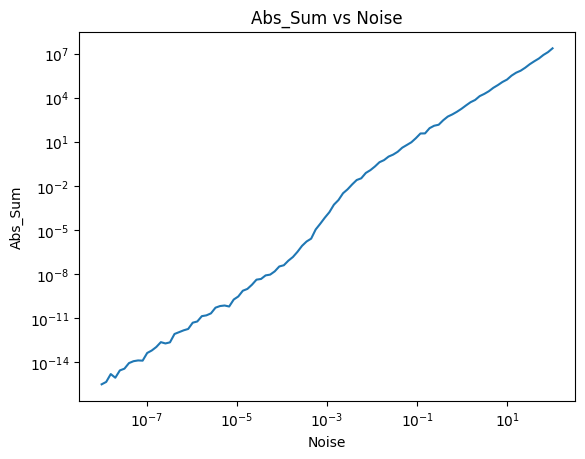

In [35]:
grouped = total_sum_df.groupby('Noise').mean().reset_index()
# grouped = grouped[grouped['Noise'] < 1]

plt.plot(grouped['Noise'], grouped['Abs_Sum'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise')
plt.ylabel('Abs_Sum')
plt.title('Abs_Sum vs Noise')
plt.show()

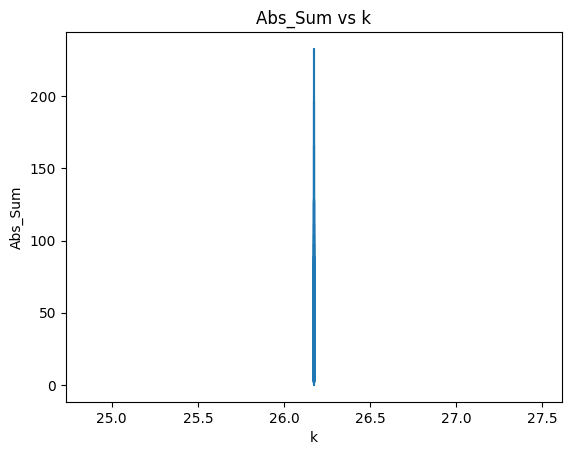

In [36]:
# Plot as a function of k:
noise_index = 70
grouped_k = total_sum_df[total_sum_df['Noise'] == noise_values[noise_index]]

plt.plot(grouped_k['k_square'], grouped_k['Abs_Sum'])
plt.xlabel('k')
plt.ylabel('Abs_Sum')
plt.title('Abs_Sum vs k')
plt.show()

In [ ]:
grouped_k['k'].max()

45.254833995939045

## Changing K

In [37]:
num_exp = 100
noise_values = np.logspace(start = -8, stop = 2, num = 100)
summands_lists = [] * len(noise_values)
summands_means = np.zeros(len(noise_values))
B_xs = np.zeros((resolution, resolution, len(noise_values)))

total_sum_df = pd.DataFrame(columns=['Noise', 'Abs_Sum'])
# k = np.random.randint(1, resolution + 1, size=2)

for noise in tqdm(noise_values):
    for i in range(num_exp):
        # Randomly select image indexes and category indexes
        image_indexes = np.random.randint(0, 10, 2)
        category_indexes = np.random.randint(0, 10, 2)
        
        # Create image instances
        image1 = Image(resolution, category_names[category_indexes[0]], image_numbers[image_indexes[0]], full_path)
        image2 = Image(resolution, category_names[category_indexes[1]], image_numbers[image_indexes[1]], full_path)
        
        # Process images
        results = Image.process_images(image1, image2, noise)
        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1

        sum_left = 0
        sum_right = 0
        k = np.random.randint(1, resolution + 1, size=2)
        
        # Calculate sum_left and sum_right according to line 44
        for x in range(resolution):
            for y in range(resolution):
                B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                location = np.array([x, y])
                exponent = np.exp(-1j * np.dot(location, k))
                sum_left += exponent * B_x
                exponent = np.exp(1j * np.dot(location, k))
                sum_right += exponent * B_x
        
        # Compute absolute sum
        abs_sum = abs(sum_left * sum_right)
        
        # Append results to DataFrame
        total_sum_df = total_sum_df._append({
            'Noise': noise,
            'Sum_Left': sum_left,
            'Sum_Right': sum_right,
            'alpha_1': alpha_1,
            'alpha_2': alpha_2,
            'k': k,
            'Abs_Sum': abs_sum
        }, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_8136\242184640.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_sum_df = total_sum_df._append({
100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


In [38]:
total_sum_df['k_square'] = total_sum_df['k'].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2))
total_sum_df.head()

,Noise,Abs_Sum,Sum_Left,Sum_Right,alpha_1,alpha_2,k,k_square
0,1.000000e-08,1.474897e-19,-3.164385e-10+2.176151e- 10j,-3.164385e-10-2.176151e- 10j,-1.687475e-07,-1.877202e-07,"[3, 29]",29.154759
1,1.000000e-08,5.098196e-17,6.967123e-09-1.562422e- 09j,6.967123e-09+1.562422e- 09j,9.748942e-08,3.593434e-07,"[3, 28]",28.160256
2,1.000000e-08,1.226540e-20,-1.107090e-10-2.985826e- 12j,-1.107090e-10+2.985826e- 12j,-1.846371e-07,-9.945936e-08,"[32, 16]",35.777088
3,1.000000e-08,9.502791e-17,-5.658119e-09+7.938110e- 09j,-5.658119e-09-7.938110e- 09j,-5.275577e-07,3.427277e-07,"[15, 27]",30.886890
4,1.000000e-08,1.380973e-18,9.556419e-10-6.839018e- 10j,9.556419e-10+6.839018e- 10j,-8.962019e-08,9.981033e-08,"[4, 6]",7.211103


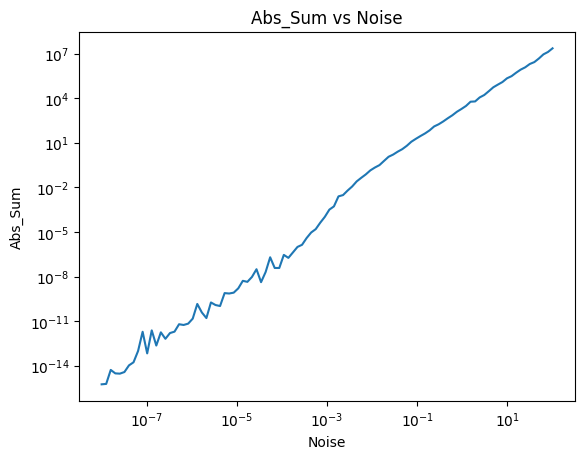

In [39]:
grouped = total_sum_df.groupby('Noise').mean().reset_index()

plt.plot(grouped['Noise'], grouped['Abs_Sum'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise')
plt.ylabel('Abs_Sum')
plt.title('Abs_Sum vs Noise')
plt.show()